Saving H1N1 cases.csv to H1N1 cases.csv
Epoch 1/50
9/9 [==============================] - 9s 68ms/step - loss: 0.0111 - val_loss: 5.5743e-04
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0013
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0012
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 6.9961e-04
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 7.1912e-04
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 7.9491e-04
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 6.9399e-04
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 6.1019e-04
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 5.5793e-04
Epoch 10/50
9/9 [==============================] - 0s 6ms/step - lo

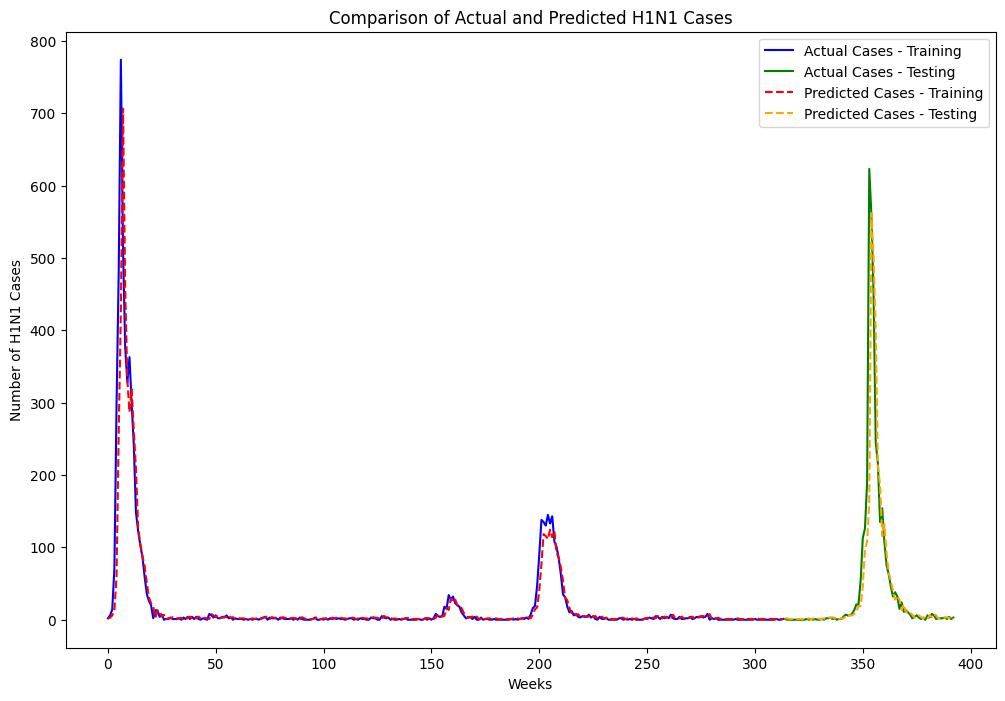

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Renaming columns for clarity
data.columns = ['Week', 'Cases']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Cases'] = scaler.fit_transform(data[['Cases']])

# Prepare the sequences
window_size = 1

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences using the 'Cases' column
X, y = create_sequences(data['Cases'].values, window_size)

# Reshape for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),  # 50 LSTM units
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(1)  # Output a single value
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predict using both train and test set
train_predictions_normalized = model.predict(X_train)
test_predictions_normalized = model.predict(X_test)

# Inverse transform predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions_normalized)
test_predictions = scaler.inverse_transform(test_predictions_normalized)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(y_train_original, label='Actual Cases - Training', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_original, label='Actual Cases - Testing', color='green')
plt.plot(train_predictions, label='Predicted Cases - Training', linestyle='--', color='red')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Predicted Cases - Testing', linestyle='--', color='orange')
plt.title('Comparison of Actual and Predicted H1N1 Cases')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # To avoid division by zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Calculate MAPE for the training and testing sets
mape_train = mean_absolute_percentage_error(y_train_original, train_predictions)
mape_test = mean_absolute_percentage_error(y_test_original, test_predictions)

# Calculate R-squared for the training and testing sets
r2_train = r2_score(y_train_original, train_predictions)
r2_test = r2_score(y_test_original, test_predictions)

# Output the calculated metrics
print("Training MAPE:", mape_train)
print("Testing MAPE:", mape_test)
print("Training R-squared:", r2_train)
print("Testing R-squared:", r2_test)


Training MAPE: 69.54601966377626
Testing MAPE: 60.45910629487319
Training R-squared: 0.8365632285111838
Testing R-squared: 0.7418238766322509


In [ ]:
import pandas as pd

# Convert the arrays to pandas DataFrames for easy manipulation and display
train_data = pd.DataFrame({
    'Actual Training Cases': y_train_original.flatten(),
    'Predicted Training Cases': train_predictions.flatten()
})

test_data = pd.DataFrame({
    'Actual Testing Cases': y_test_original.flatten(),
    'Predicted Testing Cases': test_predictions.flatten()
})

# Print the DataFrames to see the actual and predicted values
print("Training Data: Actual vs Predicted")
print(train_data)
print("\nTesting Data: Actual vs Predicted")
print(test_data)


Training Data: Actual vs Predicted
     Actual Training Cases  Predicted Training Cases
0                      2.0                  1.856283
1                      6.0                  2.688769
2                     14.0                  6.021378
3                     71.0                 12.699344
4                    297.0                 60.762947
..                     ...                       ...
309                    0.0                  1.024066
310                    1.0                  1.024066
311                    0.0                  1.856283
312                    0.0                  1.024066
313                    1.0                  1.024066

[314 rows x 2 columns]

Testing Data: Actual vs Predicted
    Actual Testing Cases  Predicted Testing Cases
0                    1.0                 1.856283
1                    0.0                 1.856283
2                    0.0                 1.024066
3                    0.0                 1.024066
4                   